RandomizedSearchCV Time: 364.85 seconds
Accuracy: 0.969
Recall: 0.433
Precision: 0.886


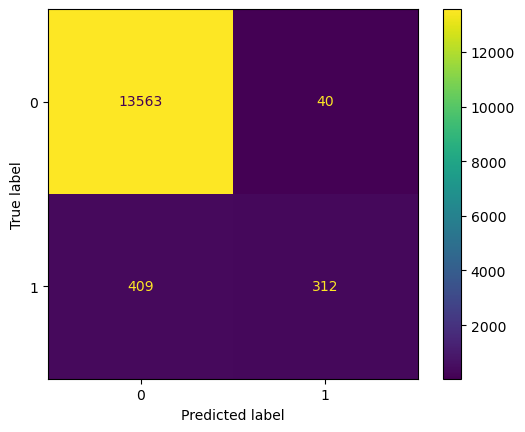

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

# Load CSV file
file_path = "merged_data.csv"  # Ensure the file is in your working directory

# Read the dataset
df = pd.read_csv(file_path)

# Convert class labels to integers if needed
df['class'] = df['class'].replace({b'0': 0, b'1': 1}).astype(int)

# Drop specified columns if they exist
df = df.drop(["Attr21", "Attr37"], axis=1, errors='ignore')

# Prepare train/test data
X = df.loc[:, df.columns != 'class'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Impute missing values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp_mean.fit_transform(X_train)
X_test = imp_mean.transform(X_test)

# Normalize data
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# Build classifier
clf = RandomForestClassifier(n_estimators=20)

# Define hyperparameter search space
param_dist = {
    "max_depth": [3, None],
    "max_features": sp_randint(1, 11),
    "min_samples_split": sp_randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

# Run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, random_state=42)
start = time()
random_search.fit(X_train, y_train)
search_time = time() - start

# Evaluate model
y_hat_rf_test = random_search.predict(X_test)
accuracy = accuracy_score(y_hat_rf_test, y_test)
recall = recall_score(y_test, y_hat_rf_test, pos_label=1, average='binary')
precision = precision_score(y_test, y_hat_rf_test, pos_label=1, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_rf_test)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

# Print results
print(f"RandomizedSearchCV Time: {search_time:.2f} seconds")
print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")


In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier # Import GradientBoostingClassifier

# GBM 
GBM = GradientBoostingClassifier() # Create and assign the model to GBM

# Perform 5-fold cross-validation to assess model generalization
cv_scores = cross_val_score(GBM, X_train, y_train, cv=5, scoring="accuracy")

# Print results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.3f}")
print(f"Standard Deviation of Accuracy: {np.std(cv_scores):.3f}")

Cross-Validation Accuracy Scores: [0.97111913 0.96922283 0.96750344 0.97059835 0.97162999]
Mean CV Accuracy: 0.970
Standard Deviation of Accuracy: 0.001


In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier # Import GradientBoostingClassifier

#  GBM is GradientBoostingClassifier
GBM = GradientBoostingClassifier() # Create and assign the model to GBM

# Perform 5-fold cross-validation to assess model generalization
cv_scores = cross_val_score(GBM, X_train, y_train, cv=5, scoring="accuracy")

# Print results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.3f}")
print(f"Standard Deviation of Accuracy: {np.std(cv_scores):.3f}")

# Fit the model to the training data before making predictions
GBM.fit(X_train, y_train) # This line is added to fit the model

Cross-Validation Accuracy Scores: [0.97129104 0.96922283 0.96750344 0.97042641 0.97162999]
Mean CV Accuracy: 0.970
Standard Deviation of Accuracy: 0.002


GradientBoostingClassifier()

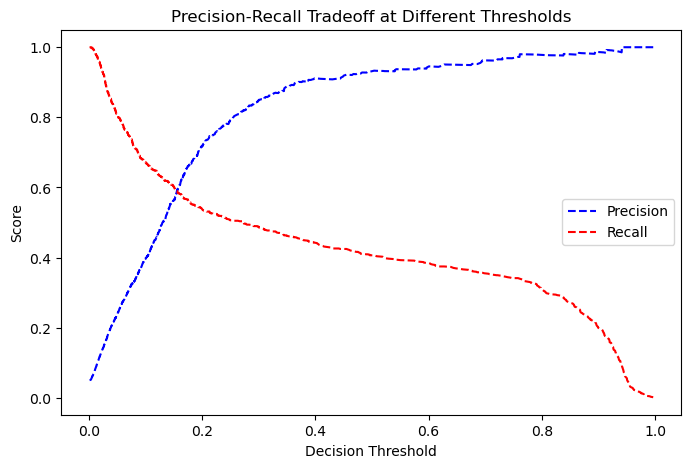

In [7]:
from sklearn.metrics import precision_recall_curve

# Compute the probability scores for the test set
y_scores_gbm = GBM.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_gbm)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r--", label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff at Different Thresholds")
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import classification_report

# Choose an alternative threshold
threshold1 = 0.3  # Aggressive (higher recall)
threshold2 = 0.7  # Conservative (higher precision)

# Convert probabilities to binary predictions
y_pred_thresh1 = (y_scores_gbm >= threshold1).astype(int)
y_pred_thresh2 = (y_scores_gbm >= threshold2).astype(int)

# Print classification reports
print("Classification Report at Threshold 0.3:")
print(classification_report(y_test, y_pred_thresh1))

print("\nClassification Report at Threshold 0.7:")
print(classification_report(y_test, y_pred_thresh2))


Classification Report at Threshold 0.3:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13603
           1       0.85      0.49      0.62       721

    accuracy                           0.97     14324
   macro avg       0.91      0.74      0.80     14324
weighted avg       0.97      0.97      0.97     14324


Classification Report at Threshold 0.7:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13603
           1       0.96      0.35      0.52       721

    accuracy                           0.97     14324
   macro avg       0.96      0.68      0.75     14324
weighted avg       0.97      0.97      0.96     14324

